In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def find_split_point(iteration):
    split_point = []
    for i in range(len(iteration)):
        if iteration[i] == 2000:
            split_point.append(i)
    return split_point

In [3]:
def parse_log_file(path):
    train_loss = []
    iteration = []
    epoch_info = []
    with open(path) as file:
        l = file.readline()
        while len(l)>0:
            l = file.readline()
            if l.startswith('Iter'):
                start = l.index('Iter')
                end = l.index(',')
                iteration.append(int(l[start+4:end].strip()))
                train_loss.append(float(l[l.index('Train Loss:')+11:].strip()))
            if l.startswith('Epoch'):
                epoch_info.append(l)
    num_epoch = len(epoch_info)
    split_point = find_split_point(iteration)
    iteration_by_epoch = []
    for i  in range(len(split_point)-1):
        split = split_point[i]
        next_split = split_point[i+1]
        iteration_by_epoch.append(iteration[split:next_split])
    iteration_by_epoch.append(iteration[next_split:])
    total_iteration_per_epoch = []
    for i in range(num_epoch):
        total_iteration_per_epoch.append(iteration_by_epoch[i][-1])
    total_iteration_per_epoch = np.array(total_iteration_per_epoch)
    N = len(iteration)
    loss_train_epoch = []
    loss_test_epoch = []
    f1_test_epoch = []
    acc_test_epoch = []
    time_epoch = []
    for i in range(num_epoch):
        epoch = epoch_info[i]
        train_start = epoch.index('train loss')
        train_end = epoch.index('test loss')
        test_start = train_end
        test_end = epoch.index('test acc')
        acc_start = test_end
        acc_end = epoch.index("test f1")
        f1_start = acc_end
        time_start = epoch.index('epoch time')
        loss_train_epoch.append(float(epoch[train_start+11:train_end-2].strip()))
        loss_test_epoch.append(float(epoch[test_start+10:test_end-2].strip()))
        acc_test_epoch.append(float(epoch[acc_start+10:acc_end-3]))
        f1_test_epoch.append(float(epoch[f1_start+9:time_start-2].strip()))
        time_epoch.append(float(epoch[time_start+12:].strip()))
    average_time_by_epoch = np.array(time_epoch)/total_iteration_per_epoch.reshape(-1,num_epoch)
    summary_epoch = pd.DataFrame({'time':time_epoch,
                'test f1':f1_test_epoch,'train loss': loss_train_epoch,
                'test loss':loss_test_epoch,
                'time per iter':average_time_by_epoch.flatten()}) 
    #create per iteration summary 
    end_points = split_point[1:]
    end_points.append(len(iteration))
    duplicate_num = np.array(end_points)-np.array(split_point)

    time =[]
    for i in range(num_epoch):
        time +=[summary_epoch['time per iter'].values[i]]*duplicate_num[i]
    cut = len(time)# this is to get rid of unfinished epoch
    accumulated_time = [2000*np.sum(time[:i])/60 for i in range(1,N+1)]
    iteration_summary = pd.DataFrame({'iteration':2000*np.arange(1,cut+1),
                                     'train loss':train_loss[:cut],
                                     'time per iter':time[:cut],
                                     'accumulated time':accumulated_time[:cut]})

    return iteration_summary,summary_epoch,train_loss[-1],

In [4]:
def parse_log_file2(path,num_gpu=2):
    train_loss = []
    iteration = []
    epoch_info = []
    with open(path) as file:
        l = file.readline()
        start = 0
        epoch_start=0
        while len(l)>0:
            l = file.readline()
            if l.startswith('Iter'):
                if start%num_gpu == 0:
                    start = l.index('Iter')
                    end = l.index(',')
                    iteration.append(int(l[start+4:end].strip()))
                    train_loss.append(float(l[l.index('Train Loss:')+11:].strip()))
                start = start+1 
            if l.startswith('Epoch'):
                if epoch_start%num_gpu == 0:
                    epoch_info.append(l)
                epoch_start = epoch_start+1
    num_epoch = len(epoch_info)
    split_point = find_split_point(iteration)
    iteration_by_epoch = []
    for i  in range(len(split_point)-1):
        split = split_point[i]
        next_split = split_point[i+1]
        iteration_by_epoch.append(iteration[split:next_split])
    iteration_by_epoch.append(iteration[next_split:])
    total_iteration_per_epoch = []
    for i in range(num_epoch):
        total_iteration_per_epoch.append(iteration_by_epoch[i][-1])
    total_iteration_per_epoch = np.array(total_iteration_per_epoch)
    N = len(iteration)
    loss_train_epoch = []
    loss_test_epoch = []
    f1_test_epoch = []
    acc_test_epoch = []
    time_epoch = []
    for i in range(num_epoch):
        epoch = epoch_info[i]
        train_start = epoch.index('train loss')
        train_end = epoch.index('test loss')
        test_start = train_end
        test_end = epoch.index('test acc')
        acc_start = test_end
        acc_end = epoch.index("test f1")
        f1_start = acc_end
        time_start = epoch.index('epoch time')
        loss_train_epoch.append(float(epoch[train_start+11:train_end-2].strip()))
        loss_test_epoch.append(float(epoch[test_start+10:test_end-2].strip()))
        acc_test_epoch.append(float(epoch[acc_start+10:acc_end-3]))
        f1_test_epoch.append(float(epoch[f1_start+9:time_start-2].strip()))
        time_epoch.append(float(epoch[time_start+12:].strip()))
    average_time_by_epoch = np.array(time_epoch)/total_iteration_per_epoch.reshape(-1,num_epoch)
    summary_epoch = pd.DataFrame({'time':time_epoch,
                'test f1':f1_test_epoch,'train loss': loss_train_epoch,
                'test loss':loss_test_epoch,
                'time per iter':average_time_by_epoch.flatten()}) 
    #create per iteration summary 
    end_points = split_point[1:]
    end_points.append(len(iteration))
    duplicate_num = np.array(end_points)-np.array(split_point)

    time =[]
    epoch_breakdown=[]
    for i in range(num_epoch):
        time +=[summary_epoch['time per iter'].values[i]]*duplicate_num[i]
        epoch_breakdown+=[1/duplicate_num[i]]*duplicate_num[i]
    epoch_breakdown = epoch_breakdown = [np.sum(epoch_breakdown[:i]) for i in range(1,N+1)]
    cut = len(time)# this is to get rid of unfinished epoch
    accumulated_time = [2000*np.sum(time[:i])/60 for i in range(1,N+1)]
    iteration_summary = pd.DataFrame({'iteration':2000*np.arange(1,cut+1),
                                     'train loss':train_loss[:cut],
                                     'time per iter':time[:cut],
                                     'accumulated time':accumulated_time[:cut],
                                     'epoch':epoch_breakdown})
    return iteration_summary,summary_epoch,train_loss[-1],

In [110]:
iteration_summary1,summary_epoch1,train_loss1 = parse_log_file2('Log/log_single.out',1)

In [111]:
iteration_summary,summary_epoch,train_loss = parse_log_file2('Log/log_2.out')

In [120]:
!ls log

log_2.out           log_single.out      log_single_prof.out


In [121]:
iteration_summary3,summary_epoch3,train_loss3 = parse_log_file2('Log/log_4n.out',1)

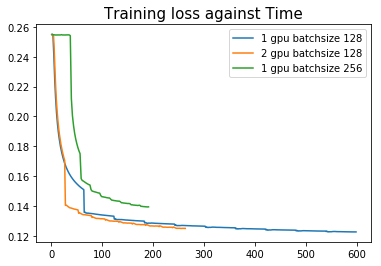

In [128]:
plt.title('Training loss against Time',fontsize= 15);
plt.plot(iteration_summary1['accumulated time'],iteration_summary1['train loss'],label = '1 gpu batchsize 128');
plt.plot(iteration_summary['accumulated time'],iteration_summary['train loss'],label = '2 gpu batchsize 128');
plt.plot(iteration_summary3['accumulated time'],iteration_summary3['train loss'],label = '1 gpu batchsize 256')
plt.legend()

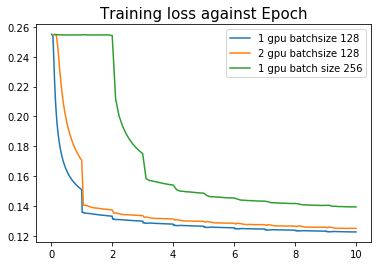

In [129]:
plt.title('Training loss against Epoch',fontsize = 15);
plt.plot(iteration_summary1['epoch'],iteration_summary1['train loss'],label = '1 gpu batchsize 128');
plt.plot(iteration_summary['epoch'],iteration_summary['train loss'],label = '2 gpu batchsize 128');
plt.plot(iteration_summary3['epoch'],iteration_summary3['train loss'],label = '1 gpu batch size 256');
plt.legend();

In [8]:
iteration_summary,summary_epoch,train_loss = parse_log_file2('Log/log_single.out',1)
iteration_summary2,summary_epoch2,train_loss2 = parse_log_file2('Log/log_2n_1g_b128.out',1)
iteration_summary3,summary_epoch3,train_loss3 = parse_log_file2('Log/log_4n_1g_b128.out',1)

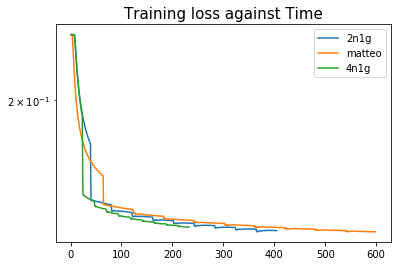

In [13]:
plt.title('Training loss against Time',fontsize= 15);
plt.semilogy(iteration_summary2['accumulated time'],iteration_summary2['train loss'],label = '2n1g');
plt.semilogy(iteration_summary['accumulated time'],iteration_summary['train loss'],label = 'matteo');
plt.semilogy(iteration_summary3['accumulated time'],iteration_summary3['train loss'],label = '4n1g')
plt.legend()

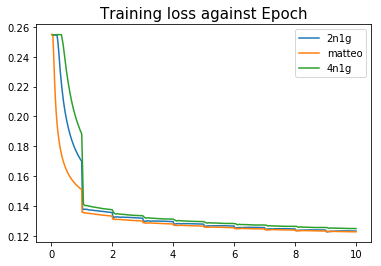

In [12]:
plt.title('Training loss against Epoch',fontsize= 15);
plt.plot(iteration_summary2['epoch'],iteration_summary2['train loss'],label = '2n1g');
plt.plot(iteration_summary['epoch'],iteration_summary['train loss'],label = 'matteo');
plt.plot(iteration_summary3['epoch'],iteration_summary3['train loss'],label = '4n1g')
plt.legend()